In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/payment-card-fraud-detection-with-ml-models-2025/luxury_cosmetics_fraud_analysis_2025.json
/kaggle/input/payment-card-fraud-detection-with-ml-models-2025/luxury_cosmetics_fraud_analysis_2025.csv
/kaggle/input/payment-card-fraud-detection-with-ml-models-2025/luxury_cosmetics_fraud_analysis_2025.xlsx


In [2]:
# Importando a base de dados

df = pd.read_csv("/kaggle/input/payment-card-fraud-detection-with-ml-models-2025/luxury_cosmetics_fraud_analysis_2025.csv")

In [3]:
# Olhando as primeiras linhas da base

df.head()

,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Time,Customer_Age,Customer_Loyalty_Tier,Location,Store_ID,Product_SKU,Product_Category,Purchase_Amount,Payment_Method,Device_Type,IP_Address,Fraud_Flag,Footfall_Count
0,702bdd9b-9c93-41e3-9dbb-a849b2422080,119dca0b-8554-4b2d-9bec-e964eaf6af97,2025-07-27,04:04:15,56.0,Silver,San Francisco,FLAGSHIP-LA,NEBULA-SERUM-07,Concealer,158.24,Mobile Payment,Desktop,239.249.58.237,0,333
1,2e64c346-36bc-4acf-bc2b-8b0fdf46abc5,299df086-26c4-4708-b6d7-fcaeceb14637,2025-03-14,20:23:23,46.0,Platinum,Zurich,BOUTIQUE-SHANGHAI,STELLAR-FOUND-03,Lipstick,86.03,Credit Card,Tablet,84.49.227.90,0,406
2,29ad1278-70ce-421f-8d81-23816b39f4ac,dfa3d24d-b935-49a5-aa1d-7d57a44d8773,2025-02-20,12:36:02,32.0,Silver,Milan,POPUP-TOKYO,SOLAR-BLUSH-04,Mascara,255.69,Gift Card,Desktop,79.207.35.55,0,96
3,07dc4894-e0eb-48f1-99a7-1942b1973d9b,7a67e184-9369-49ee-aeac-18f5b51b230f,2025-04-25,19:09:43,60.0,Bronze,London,BOUTIQUE-NYC,GALAXIA-SET-08,Serum,282.76,Gift Card,Mobile,176.194.167.253,0,186
4,ae407054-5543-429c-918a-cdcc42ea9782,cf14730a-8f5a-453d-b527-39a278852b27,2025-04-17,14:23:23,NaN,Platinum,Miami,BOUTIQUE-NYC,LUNAR-MASC-02,Serum,205.86,Gift Card,Mobile,166.31.46.111,0,179


In [4]:
# Removendo linhas com NAN

df.dropna(inplace=True)

In [5]:
# Informações gerais sobre o conjunto

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1830 entries, 0 to 2132
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Transaction_ID         1830 non-null   object 
 1   Customer_ID            1830 non-null   object 
 2   Transaction_Date       1830 non-null   object 
 3   Transaction_Time       1830 non-null   object 
 4   Customer_Age           1830 non-null   float64
 5   Customer_Loyalty_Tier  1830 non-null   object 
 6   Location               1830 non-null   object 
 7   Store_ID               1830 non-null   object 
 8   Product_SKU            1830 non-null   object 
 9   Product_Category       1830 non-null   object 
 10  Purchase_Amount        1830 non-null   float64
 11  Payment_Method         1830 non-null   object 
 12  Device_Type            1830 non-null   object 
 13  IP_Address             1830 non-null   object 
 14  Fraud_Flag             1830 non-null   int64  
 15  Footfall_

In [6]:
# Desbalanceamento das classes

df['Fraud_Flag'].value_counts()

Fraud_Flag
0    1773
1      57
Name: count, dtype: int64

In [7]:
# Vamos separar as colunas numericas das demais

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(numeric_cols)

Index(['Customer_Age', 'Purchase_Amount', 'Fraud_Flag', 'Footfall_Count'], dtype='object')


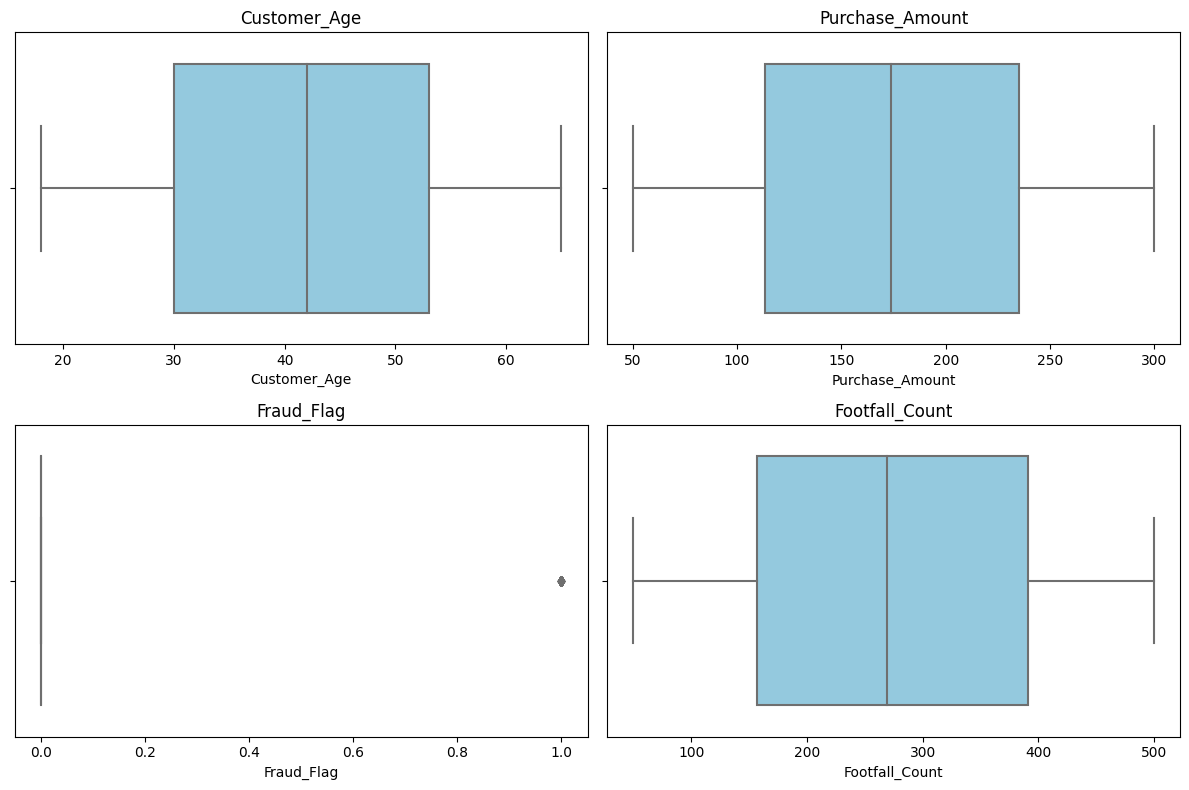

In [8]:
# Usando as colunas numericas, apresentamos os boxplots para buscar por outliers

plt.figure(figsize=(12, 8))  # Ajuste o tamanho que quiser

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 2, i+1)  # 2 linhas, 2 colunas, pois são 4 gráficos
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col, fontsize=12)

plt.tight_layout()
plt.show()

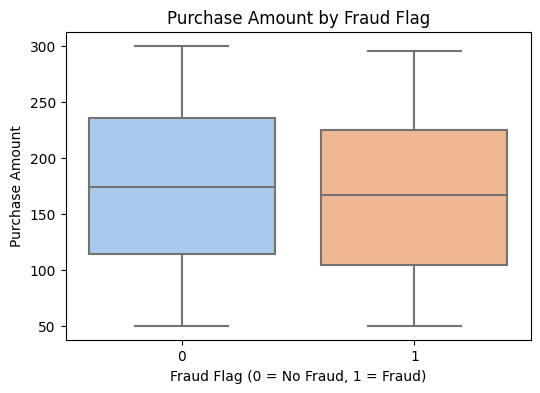

In [9]:
# Embora não tenhamos visto nada significante no gráfico de cima, tentei verificar uma relação mais particular entre a frade e o valor da compra

plt.figure(figsize=(6, 4))
sns.boxplot(x='Fraud_Flag', y='Purchase_Amount', data=df, palette='pastel')
plt.title('Purchase Amount by Fraud Flag')
plt.xlabel('Fraud Flag (0 = No Fraud, 1 = Fraud)')
plt.ylabel('Purchase Amount')
plt.show()

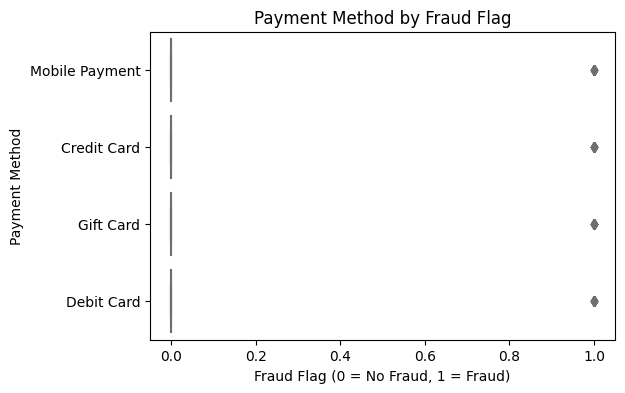

In [10]:
# Outliers identificados como fraudes em todas as diversas formas de pagamento

plt.figure(figsize=(6, 4))
sns.boxplot(x='Fraud_Flag', y='Payment_Method', data=df, palette='pastel')
plt.title('Payment Method by Fraud Flag')
plt.xlabel('Fraud Flag (0 = No Fraud, 1 = Fraud)')
plt.ylabel('Payment Method')
plt.show()

Olhando os boxplots não vemos nada de anormal nas transações, vamos tentar outros métodos estatísticos

In [11]:
# Separa os dados por grupo
grouped_means = df.groupby('Fraud_Flag').mean(numeric_only=True).T  # Transposto pra facilitar leitura

# Mostra a diferença entre os grupos
grouped_means['diff'] = grouped_means[1] - grouped_means[0]
print(grouped_means)

Fraud_Flag                0           1       diff
Customer_Age      41.573604   41.561404  -0.012201
Purchase_Amount  174.379994  161.789825 -12.590170
Footfall_Count   273.632826  279.385965   5.753139


In [12]:
# Seleciona colunas numéricas (menos a própria Fraud_Flag)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('Fraud_Flag')

# Calcula a correlação ponto-bisserial de cada coluna com Fraud_Flag
results = []

for col in numeric_cols:
    corr, pval = pointbiserialr(df['Fraud_Flag'], df[col])
    results.append({'Variável': col, 'Correlação': corr, 'p-valor': pval})

# Cria DataFrame com os resultados
import pandas as pd
corr_df = pd.DataFrame(results).sort_values(by='Correlação', key=abs, ascending=False)
print(corr_df)

          Variável  Correlação   p-valor
1  Purchase_Amount   -0.030394  0.193726
2   Footfall_Count    0.007569  0.746258
0     Customer_Age   -0.000155  0.994722


Correlações fracas (próximas de 0)

p-valores altos (> 0.05)

Não há relação estatística forte entre Fraud_Flag e essas variáveis numéricas quando analisadas isoladamente.

In [13]:
# Tabela cruzada: fraudes por tipo de pagamento
fraud_rate_by_payment = pd.crosstab(df['Payment_Method'], df['Fraud_Flag'], normalize='index') * 100

# Renomeia as colunas para clareza
fraud_rate_by_payment.columns = ['Não Fraude (%)', 'Fraude (%)']

# Exibe ordenado pela taxa de fraude
fraud_rate_by_payment = fraud_rate_by_payment.sort_values('Fraude (%)', ascending=False)
print(fraud_rate_by_payment)

                Não Fraude (%)  Fraude (%)
Payment_Method                            
Debit Card           96.521739    3.478261
Credit Card          96.825397    3.174603
Mobile Payment       96.989247    3.010753
Gift Card            97.198276    2.801724


In [14]:
# Seleciona colunas categóricas (exclui Fraud_Flag e outras irrelevantes, se necessário)
categorical_cols = df.select_dtypes(include='object').columns

results = []

for col in categorical_cols:
    try:
        # Tabela de contingência
        table = pd.crosstab(df[col], df['Fraud_Flag'])
        
        # Aplica o teste qui-quadrado
        chi2, p, dof, expected = chi2_contingency(table)
        
        # Guarda os resultados
        results.append({
            'Variável': col,
            'Qui-quadrado': chi2,
            'p-valor': p
        })
        
    except Exception as e:
        print(f"Erro com a coluna {col}: {e}")

# Converte para DataFrame
chi2_df = pd.DataFrame(results).sort_values('p-valor')
print(chi2_df)

                 Variável  Qui-quadrado   p-valor
10            Device_Type      5.712868  0.126447
5                Location     22.914207  0.241142
8        Product_Category      9.525754  0.390222
0          Transaction_ID   1830.000000  0.489009
1             Customer_ID   1830.000000  0.489009
11             IP_Address   1830.000000  0.489009
6                Store_ID      8.449105  0.489596
3        Transaction_Time   1796.862588  0.595251
4   Customer_Loyalty_Tier      2.480783  0.648080
2        Transaction_Date    164.877463  0.767764
7             Product_SKU      5.605765  0.778634
9          Payment_Method      0.373984  0.945563


p-valor < 0.05 → existe associação significativa entre método de pagamento e fraude

p-valor ≥ 0.05 → não há evidência estatística de associação

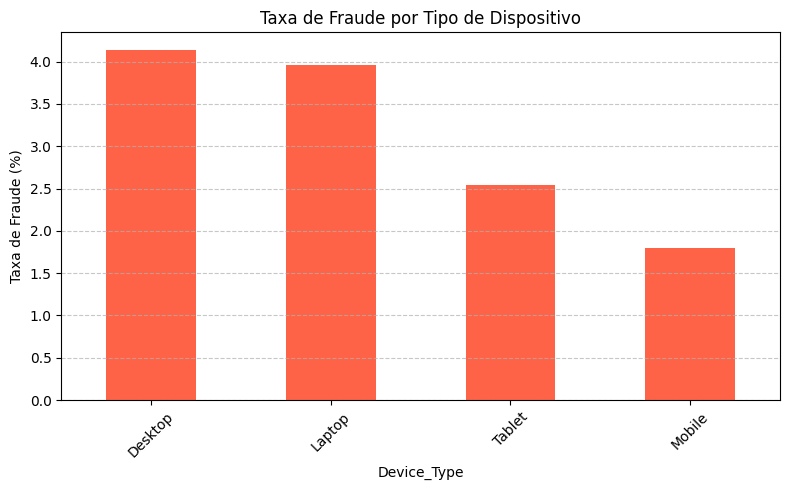

In [15]:
# Calcula a taxa de fraude por tipo de dispositivo
device_fraud_rate = pd.crosstab(df['Device_Type'], df['Fraud_Flag'], normalize='index') * 100
device_fraud_rate.columns = ['Não Fraude (%)', 'Fraude (%)']
device_fraud_rate = device_fraud_rate.sort_values('Fraude (%)', ascending=False)

# Gráfico
device_fraud_rate['Fraude (%)'].plot(kind='bar', color='tomato', figsize=(8,5))
plt.ylabel('Taxa de Fraude (%)')
plt.title('Taxa de Fraude por Tipo de Dispositivo')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

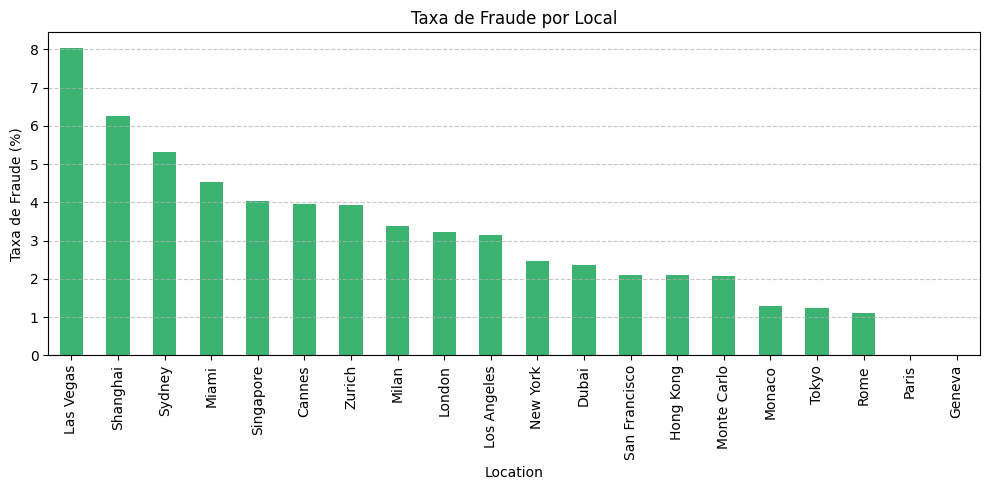

In [16]:
# Taxa de fraude por local
location_fraud_rate = pd.crosstab(df['Location'], df['Fraud_Flag'], normalize='index') * 100
location_fraud_rate.columns = ['Não Fraude (%)', 'Fraude (%)']
location_fraud_rate = location_fraud_rate.sort_values('Fraude (%)', ascending=False)

# Gráfico
location_fraud_rate['Fraude (%)'].plot(kind='bar', color='mediumseagreen', figsize=(10,5))
plt.ylabel('Taxa de Fraude (%)')
plt.title('Taxa de Fraude por Local')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

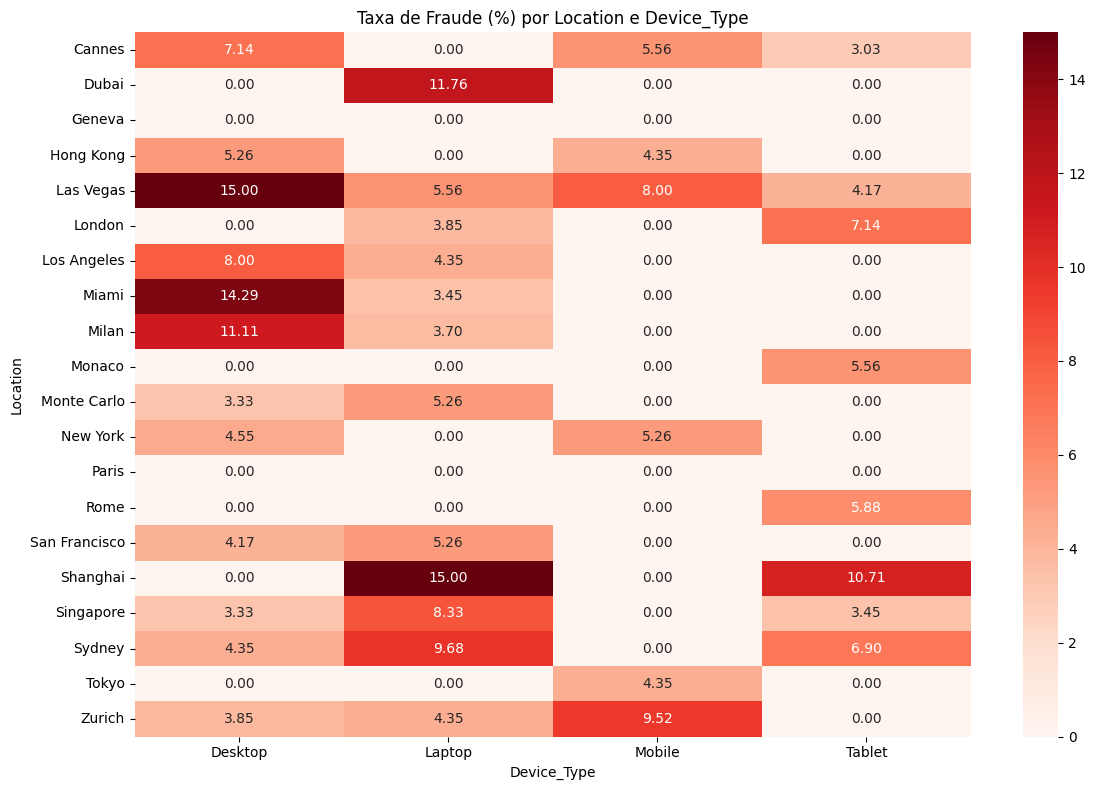

In [17]:
# Cria uma tabela de contingência com múltiplos índices
cross_tab = pd.crosstab([df['Location'], df['Device_Type']], df['Fraud_Flag'], normalize='index') * 100
cross_tab.columns = ['Não Fraude (%)', 'Fraude (%)']

# Seleciona apenas a coluna Fraude (%)
fraud_rates = cross_tab['Fraude (%)'].unstack()  # Para facilitar visualização

# Plotar um heatmap para visualizar melhor
plt.figure(figsize=(12, 8))
sns.heatmap(fraud_rates, annot=True, fmt=".2f", cmap="Reds")
plt.title('Taxa de Fraude (%) por Location e Device_Type')
plt.ylabel('Location')
plt.xlabel('Device_Type')
plt.tight_layout()
plt.show()

In [18]:
# A ideia aqui é definir um grupo de risco para auxiliar na identificação das fraudes

# Definir limiar
threshold = 7

# Usar a tabela fraud_rates que criamos antes
high_risk_combinations = fraud_rates.stack()[fraud_rates.stack() > threshold].index.tolist()

# Função para marcar risco alto
def mark_high_risk(row):
    return 1 if (row['Location'], row['Device_Type']) in high_risk_combinations else 0

# Criar a nova coluna no DataFrame original
df['high_fraud_risk'] = df.apply(mark_high_risk, axis=1)

# Verificar quantos registros ficaram marcados
print(df['high_fraud_risk'].value_counts())


high_fraud_risk
0    1524
1     306
Name: count, dtype: int64


In [19]:
# O grupo de fato ajuda na identificação

pd.crosstab(df['high_fraud_risk'], df['Fraud_Flag'], margins=True)
fraud_rate_by_risk = df.groupby('high_fraud_risk')['Fraud_Flag'].mean() * 100
print(fraud_rate_by_risk)


high_fraud_risk
0     1.706037
1    10.130719
Name: Fraud_Flag, dtype: float64


In [20]:
contingency_table = pd.crosstab(df['high_fraud_risk'], df['Fraud_Flag'])

# Teste qui-quadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Estatística Qui-quadrado: {chi2:.4f}')
print(f'Valor-p: {p:.4f}')

Estatística Qui-quadrado: 57.1758
Valor-p: 0.0000


Estatística Qui-quadrado: 57.18 (valor alto, indicando que as distribuições diferem bastante)

Valor-p: 0.0000 (ou seja, menor que qualquer nível comum de significância, tipo 0.05)

Há uma associação estatisticamente significativa entre estar no grupo de alto risco e a ocorrência de fraude.

Isso confirma que a variável que criamos tem valor real para diferenciar casos de fraude.

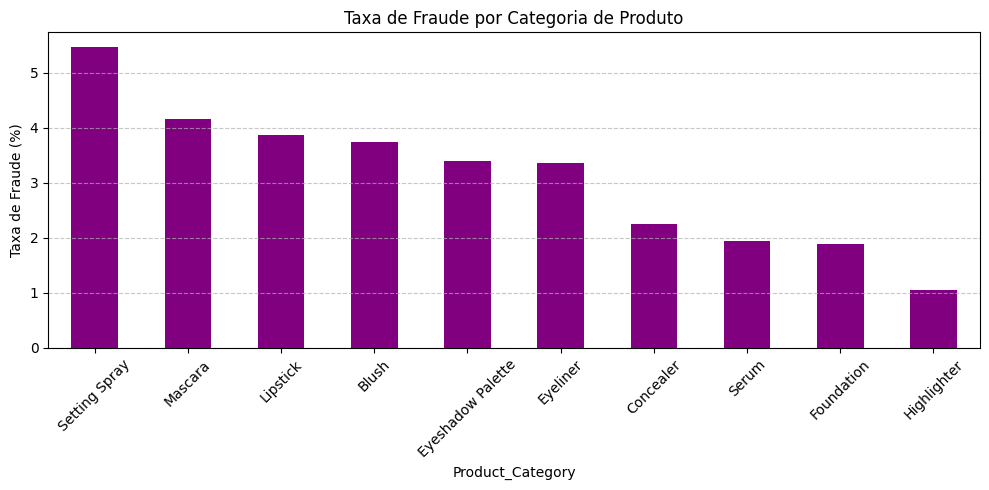

In [21]:
# Taxa de fraude por produto

category_fraud_rate = pd.crosstab(df['Product_Category'], df['Fraud_Flag'], normalize='index') * 100
category_fraud_rate.columns = ['Não Fraude (%)', 'Fraude (%)']
category_fraud_rate = category_fraud_rate.sort_values('Fraude (%)', ascending=False)

category_fraud_rate['Fraude (%)'].plot(kind='bar', color='purple', figsize=(10,5))
plt.ylabel('Taxa de Fraude (%)')
plt.title('Taxa de Fraude por Categoria de Produto')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

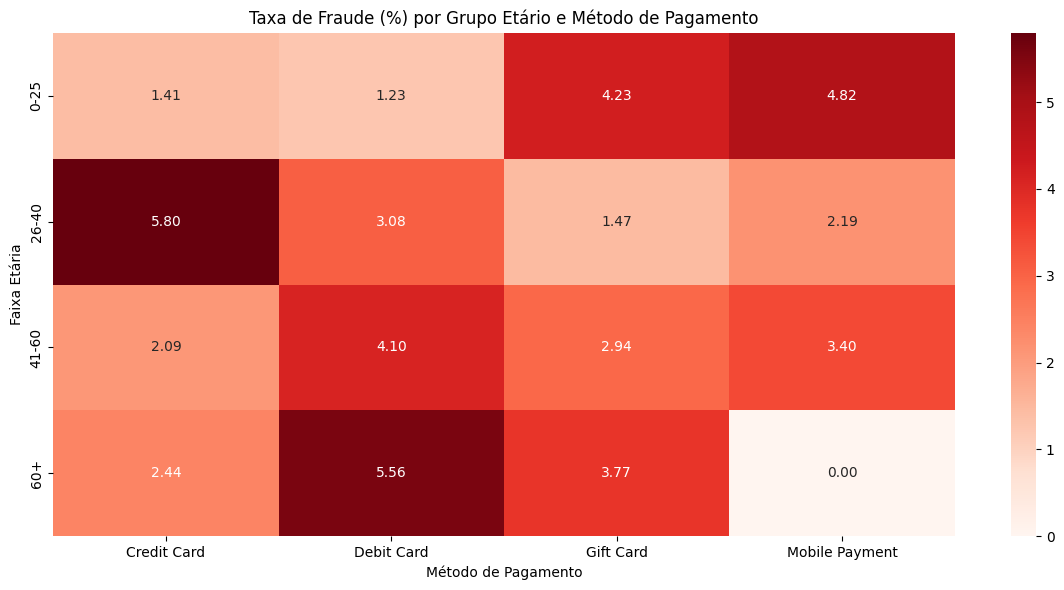

In [22]:
# Verificamos a quantidade de fraudes por grupo de faixa etária

# Criar bins para Customer_Age
df['Age_Group'] = pd.cut(df['Customer_Age'], bins=[0, 25, 40, 60, 100], labels=['0-25', '26-40', '41-60', '60+'])

# Cruzar Age_Group e Payment_Method para taxa de fraude
age_payment_fraud = pd.crosstab([df['Age_Group'], df['Payment_Method']], df['Fraud_Flag'], normalize='index') * 100
age_payment_fraud.columns = ['Não Fraude (%)', 'Fraude (%)']

# Filtrar só Fraude (%)
age_payment_fraud = age_payment_fraud['Fraude (%)'].unstack()

# Heatmap para visualizar
plt.figure(figsize=(12, 6))
sns.heatmap(age_payment_fraud, annot=True, fmt=".2f", cmap="Reds")
plt.title('Taxa de Fraude (%) por Grupo Etário e Método de Pagamento')
plt.ylabel('Faixa Etária')
plt.xlabel('Método de Pagamento')
plt.tight_layout()
plt.show()

In [23]:
df['Age_Payment'] = df['Age_Group'].astype(str) + '_' + df['Payment_Method'].astype(str)

# Tabela de contingência
contingency = pd.crosstab(df['Age_Payment'], df['Fraud_Flag'])

# Teste qui-quadrado
chi2, p, dof, expected = chi2_contingency(contingency)

print(f'Estatística Qui-quadrado: {chi2:.4f}')
print(f'Valor-p: {p:.4f}')


Estatística Qui-quadrado: 11.4437
Valor-p: 0.7206


Não há evidência estatística para rejeitar a hipótese nula, ou seja, a combinação de Age_Group com Payment_Method não está associada de forma significativa com o Fraud_Flag neste conjunto de dados.

Em outras palavras, apesar de alguns grupos parecerem ter taxas maiores visualmente, essa diferença pode ser explicada pelo acaso.